In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from skimage import io
import numpy as np
import os
from PIL import Image

In [2]:
# !mkdir digit
!unzip '/content/drive/MyDrive/soft_computing/Dataset C.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19299.png   
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   

In [3]:
training_csv = pd.read_csv('/content/training-c.csv')
# training_csv.head()
training_csv.drop(['original filename', 'scanid', 'database name original', 'contributing team', 'database name'], axis = 1, inplace = True)
training_csv.head()

,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [4]:
print(len(training_csv))

24298


In [5]:
training_csv.to_csv('train.csv')

In [6]:
test = pd.read_csv('train.csv')
test.iloc[0, 2]

6

In [7]:
batch_size = 128
num_iters = 20000
input_dim = 90*90 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class OnkoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(img_path).convert('L')
        y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [9]:
transform_dataset = transforms.Compose([
    transforms.Resize(90),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

dataset = OnkoDataset(csv_file = 'train.csv', root_dir = '/content/training-c', transform=transform_dataset)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [10]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [11]:
print(len(train_dataset))
print(len(test_dataset))
# One Image Size
print(train_dataset[0][0].shape)
print(train_dataset[0][0].numpy().shape)
# First Image Label
print(train_dataset[0][1])
train_dataset

19438
4860
torch.Size([1, 90, 90])
(1, 90, 90)
tensor(2)


tensor(2)


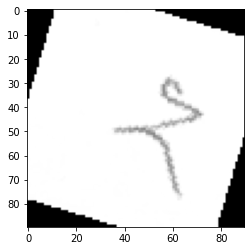

In [12]:
import matplotlib.pyplot as plt 
import numpy as np

show_img = train_dataset[0][0].numpy().reshape(90, 90)
plt.imshow(show_img, cmap='gray')
print(train_dataset[0][1])

In [13]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 200
        self.linear_1 = nn.Linear(input_size, 10000)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        # ### 2nd hidden layer: 200 --> 200
        # self.linear_2 = nn.Linear(12000, 6000)
        # ### Non-linearity in 2nd hidden layer
        # self.relu_2 = nn.ReLU()

        # ### 3rd hidden layer: 200 --> 200
        # self.linear_3 = nn.Linear(6000, 3000)
        # ### Non-linearity in 3rd hidden layer
        # self.relu_3 = nn.ReLU()

        # ### 4th hidden layer: 200 --> 200
        # self.linear_4 = nn.Linear(3000, 1500)
        # ### Non-linearity in 4th hidden layer
        # self.relu_4 = nn.ReLU()

        # ### 5th hidden layer: 200 --> 200
        # self.linear_5 = nn.Linear(1500, 750)
        # ### Non-linearity in 5th hidden layer
        # self.relu_5 = nn.ReLU()

        # ### 6th hidden layer: 200 --> 200
        # self.linear_6 = nn.Linear(750, 375)
        # ### Non-linearity in 6th hidden layer
        # self.relu_6 = nn.ReLU()

        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(10000, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        # ### 2nd hidden layer
        # out  = self.linear_2(out)
        # ### Non-linearity in 2nd hidden layer
        # out = self.relu_2(out)

        # ### 3rd hidden layer
        # out  = self.linear_3(out)
        # ### Non-linearity in 3rd hidden layer
        # out = self.relu_3(out)

        # ### 4th hidden layer
        # out  = self.linear_4(out)
        # ### Non-linearity in 4th hidden layer
        # out = self.relu_4(out)

        # ### 5th hidden layer
        # out  = self.linear_5(out)
        # ### Non-linearity in 4th hidden layer
        # out = self.relu_5(out)

        # ### 6th hidden layer
        # out  = self.linear_6(out)
        # ### Non-linearity in 5th hidden layer
        # out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=8100, out_features=10000, bias=True)
  (relu_1): ReLU()
  (linear_out): Linear(in_features=10000, out_features=10, bias=True)
)

In [14]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_values = []
accuracy_values = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            loss_values.append(loss.item())
            accuracy_values.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2612831592559814. Accuracy: 15.473251028806585
Iteration: 1000. Loss: 2.2633280754089355. Accuracy: 12.757201646090534
Iteration: 1500. Loss: 2.2090096473693848. Accuracy: 15.493827160493828
Iteration: 2000. Loss: 2.2931509017944336. Accuracy: 14.135802469135802
Iteration: 2500. Loss: 2.2801918983459473. Accuracy: 22.037037037037038
Iteration: 3000. Loss: 2.206284523010254. Accuracy: 16.810699588477366
Iteration: 3500. Loss: 2.2006633281707764. Accuracy: 28.97119341563786
Iteration: 4000. Loss: 2.1017842292785645. Accuracy: 21.810699588477366
Iteration: 4500. Loss: 2.145583152770996. Accuracy: 19.79423868312757
Iteration: 5000. Loss: 2.0474581718444824. Accuracy: 25.53497942386831
Iteration: 5500. Loss: 2.0131959915161133. Accuracy: 26.069958847736626
Iteration: 6000. Loss: 2.0836708545684814. Accuracy: 26.728395061728396
Iteration: 6500. Loss: 2.0729589462280273. Accuracy: 28.580246913580247
Iteration: 7000. Loss: 2.097785711288452. Accuracy: 28.82716049382716


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

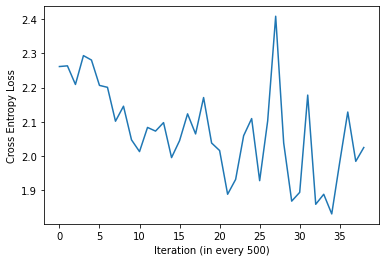

In [16]:
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files

# print (loss_values)
plt.plot(loss_values)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
# plt.show()
plt.savefig('size_90_layer_1_10000_loss_2.png',  bbox_inches="tight")
files.download('size_90_layer_1_10000_loss_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

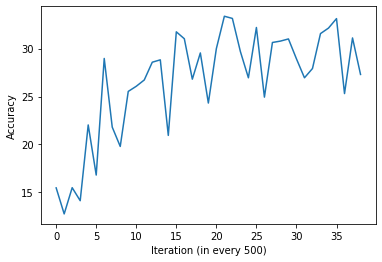

In [17]:
plt.plot(accuracy_values)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 500)')
# plt.show()
plt.savefig('size_90_layer_1_10000_acc_2.png',  bbox_inches="tight")
files.download('size_90_layer_1_10000_acc_2.png')